In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from datetime import date
import calendar

In [2]:
pwd

'/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Code'

In [3]:
Jan = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/January.xlsx')  
Feb = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/February.xlsx')  
Mar = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/March.xlsx')
Apr = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/April.xlsx')
May = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/May.xlsx')
Jun = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/June.xlsx')
Jul = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/July.xlsx')
Aug = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/August.xlsx')
Sept1 = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/September1.xlsx')
Sept2 = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/September2.xlsx')
Sept3 = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/September3.xlsx')
Sept = Sept1.append(Sept2, ignore_index=True).append(Sept3,ignore_index = True)
Oct = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/October.xlsx')
Nov = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/November.xlsx')
Dec1 = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/December1.xlsx')
Dec2 = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/December2.xlsx')
Dec = Dec1.append(Dec2, ignore_index=True)

In [4]:
Jan['Month'] = 'January'
Feb['Month'] = 'February'
Mar['Month'] = 'March'
Apr['Month'] = 'April'
May['Month'] = 'May'
Jun['Month'] = 'June'
Jul['Month'] = 'July'
Aug['Month'] = 'August'
Sept['Month'] = 'September'
Oct['Month'] = 'October'
Nov['Month'] = 'November'
Dec['Month'] = 'December'

In [5]:
Jan.dtypes

Media                       object
Estimate                    object
Access                      object
DMA                         object
Market                      object
Station ID                   int64
Length                       int64
Date Aired          datetime64[ns]
Time Aired                  object
Spot Cost                  float64
Spot Type                   object
GRP                        float64
Impression (000)           float64
Month                       object
dtype: object

In [6]:
col_names = ['Media','Estimate','Access','DMA','Market','StationId','Length','Date','Time','Spot_Cost','Spot_Type','GRP','IMP','Month']


In [7]:
Jan.columns = col_names
Feb.columns = col_names
Mar.columns = col_names
Apr.columns = col_names
May.columns = col_names
Jun.columns = col_names
Jul.columns = col_names
Aug.columns = col_names
Sept.columns = col_names
Oct.columns = col_names
Nov.columns = col_names
Dec.columns = col_names

In [8]:
dat = Jan.append(Feb, ignore_index=True).append(Mar, ignore_index=True).append(Apr, ignore_index=True).append(May, ignore_index=True).append(Jun, ignore_index=True).append(Jul, ignore_index=True).append(Aug, ignore_index=True).append(Sept, ignore_index=True).append(Oct, ignore_index=True).append(Nov, ignore_index=True).append(Dec, ignore_index=True)
dat.head()

,Media,Estimate,Access,DMA,Market,StationId,Length,Date,Time,Spot_Cost,Spot_Type,GRP,IMP,Month
0,TV,Q119,30GD,900,National Network,37,30,2018-12-31,00:06:00,56.0,INV,0.000,0.0,January
1,TV,Q119,30TN,900,Cable,202,30,2018-12-31,00:07:00,56.0,INV,0.000,0.0,January
2,TV,Q119,30PM,900,Cable,253,30,2018-12-31,00:09:00,142.4,INV,0.016,27.2,January
3,TV,Q119,30PM,900,Cable,340,30,2018-12-31,00:09:00,64.0,INV,0.128,158.4,January
4,TV,Q119,30GD,900,Cable,168,30,2018-12-31,00:10:00,56.0,INV,0.000,0.0,January


In [9]:
#d1 = dat[(dat.GRP != 0) & (dat.IMP != 0)]   

In [10]:
dat.dtypes

Media                object
Estimate             object
Access               object
DMA                  object
Market               object
StationId             int64
Length                int64
Date         datetime64[ns]
Time                 object
Spot_Cost           float64
Spot_Type            object
GRP                 float64
IMP                 float64
Month                object
dtype: object

In [11]:
dtypes = {
    "Media": str,
    "Estimate": str,
    "Access": str,
    "DMA": str,
    "Market": str,
    "StationId": str,
    "Length": int,
    "Date": str,
    "Time": str,
    "Spot_Cost": float,
    "Spot_Type": str,
    "GRP": float,
    "IMP": float,
    "Month": str,
}

dat = dat.astype(dtypes)

In [12]:
dat.dtypes

Media         object
Estimate      object
Access        object
DMA           object
Market        object
StationId     object
Length         int64
Date          object
Time          object
Spot_Cost    float64
Spot_Type     object
GRP          float64
IMP          float64
Month         object
dtype: object

In [13]:
dat.head()

,Media,Estimate,Access,DMA,Market,StationId,Length,Date,Time,Spot_Cost,Spot_Type,GRP,IMP,Month
0,TV,Q119,30GD,900,National Network,37,30,2018-12-31,00:06:00,56.0,INV,0.000,0.0,January
1,TV,Q119,30TN,900,Cable,202,30,2018-12-31,00:07:00,56.0,INV,0.000,0.0,January
2,TV,Q119,30PM,900,Cable,253,30,2018-12-31,00:09:00,142.4,INV,0.016,27.2,January
3,TV,Q119,30PM,900,Cable,340,30,2018-12-31,00:09:00,64.0,INV,0.128,158.4,January
4,TV,Q119,30GD,900,Cable,168,30,2018-12-31,00:10:00,56.0,INV,0.000,0.0,January


In [14]:
dat["Date"] = pd.to_datetime(dat["Date"], format="%Y-%m-%d")

In [15]:
dat["Day_Of_Week"] = dat["Date"].dt.day_name()

In [16]:
dat["Hour_Slot"] = dat.loc[:,'Time'].apply(lambda x: (x[:2]))

In [17]:
dat.Hour_Slot.unique()

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23'], dtype=object)

In [18]:
dat["Access"] = dat.loc[:,'Access'].apply(lambda x: (x[2:]))

In [19]:
dat.head()

,Media,Estimate,Access,DMA,Market,StationId,Length,Date,Time,Spot_Cost,Spot_Type,GRP,IMP,Month,Day_Of_Week,Hour_Slot
0,TV,Q119,GD,900,National Network,37,30,2018-12-31,00:06:00,56.0,INV,0.000,0.0,January,Monday,00
1,TV,Q119,TN,900,Cable,202,30,2018-12-31,00:07:00,56.0,INV,0.000,0.0,January,Monday,00
2,TV,Q119,PM,900,Cable,253,30,2018-12-31,00:09:00,142.4,INV,0.016,27.2,January,Monday,00
3,TV,Q119,PM,900,Cable,340,30,2018-12-31,00:09:00,64.0,INV,0.128,158.4,January,Monday,00
4,TV,Q119,GD,900,Cable,168,30,2018-12-31,00:10:00,56.0,INV,0.000,0.0,January,Monday,00


## Dealing with Station Outliers

Used the list of outliers to identify outlier stations 


In [20]:
Outlier_List = ['216','184','200','311','352','10','192','15','280','252','224','350','55','95','72','28','230','140','57','345']


In [21]:
dat['Outlier'] = dat.StationId.apply(lambda x: 'yes' if x in Outlier_List else 'no')

In [22]:
dat['Outlier_Level'] = dat.Outlier.apply(lambda x: '0' if x == 'no' else '1')

In [23]:
dat.loc[dat['Outlier_Level'] == '1','Outlier_Level'] = pd.cut(dat[dat.Outlier == 'yes']['IMP'],5, labels=["1", "2", "3",'4','5'])

In [24]:
dat.Outlier_Level.unique()

array(['0', '1', '2', '3', '4', '5'], dtype=object)

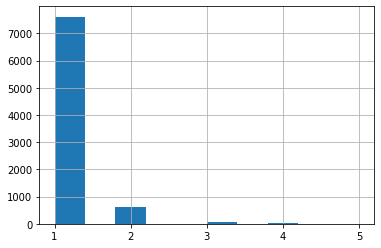

In [25]:
pd.cut(dat[dat.Outlier == 'yes']['IMP'],5, labels=["1", "2", "3",'4','5']).hist()

In [26]:
dat.head()

,Media,Estimate,Access,DMA,Market,StationId,Length,Date,Time,Spot_Cost,Spot_Type,GRP,IMP,Month,Day_Of_Week,Hour_Slot,Outlier,Outlier_Level
0,TV,Q119,GD,900,National Network,37,30,2018-12-31,00:06:00,56.0,INV,0.000,0.0,January,Monday,00,no,0
1,TV,Q119,TN,900,Cable,202,30,2018-12-31,00:07:00,56.0,INV,0.000,0.0,January,Monday,00,no,0
2,TV,Q119,PM,900,Cable,253,30,2018-12-31,00:09:00,142.4,INV,0.016,27.2,January,Monday,00,no,0
3,TV,Q119,PM,900,Cable,340,30,2018-12-31,00:09:00,64.0,INV,0.128,158.4,January,Monday,00,no,0
4,TV,Q119,GD,900,Cable,168,30,2018-12-31,00:10:00,56.0,INV,0.000,0.0,January,Monday,00,no,0


## Feature Selection and Split

In [27]:
req = ['Estimate','Access','Market','StationId','Length','Spot_Cost','Spot_Type','Month','Day_Of_Week','Hour_Slot','Outlier','Outlier_Level','IMP']
d1 = dat.loc[:,req]


In [28]:
d2 = pd.get_dummies(d1)

In [29]:
rated = d2.loc[d2.IMP != 0]
unrated = d2.loc[d2.IMP == 0]

In [30]:
#Get test data to predict IMP ...unrated

test_data = unrated.drop(['IMP'], axis = 1)
test_data.head()

,Length,Spot_Cost,Estimate_Q119,Estimate_Q219,Estimate_Q319,Estimate_Q419,Access_15,Access_BP,Access_DC,Access_DE,...,Hour_Slot_22,Hour_Slot_23,Outlier_no,Outlier_yes,Outlier_Level_0,Outlier_Level_1,Outlier_Level_2,Outlier_Level_3,Outlier_Level_4,Outlier_Level_5
0,30,56.0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,30,56.0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,30,56.0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
5,30,268.8,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
6,30,80.0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [31]:
# Use rated data to split into train and validation
label = rated['IMP']
features = rated.drop(['IMP'], axis = 1)

from sklearn.model_selection import train_test_split  

X_train, X_valid, y_train, y_valid = train_test_split(features,label,test_size = 0.3,random_state = 1234)  

print("Training set has {} samples.".format(X_train.shape[0])) 
print("Validation set has {} samples.".format(X_valid.shape[0]))

Training set has 55638 samples.
Validation set has 23846 samples.


## XGBoost Implementation

In [32]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
rmse = mean_squared_error(y_valid, clf.predict(X_valid),squared=False)
print("RMSE: %.4f" % rmse)


RMSE: 24.2072


Text(0, 0.5, 'Deviance')

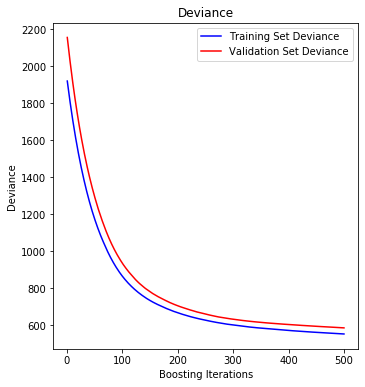

In [33]:
# Plot training deviance

# compute test set deviance
valid_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_valid)):
    valid_score[i] = clf.loss_(y_valid, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, valid_score, 'r-',
         label='Validation Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

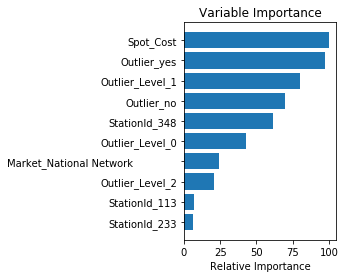

In [34]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-10:]
pos = (np.arange(sorted_idx.shape[0]) + .5)[-10:]
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## XGBoost Hyper paramter tuning

In [35]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [5,10,20],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [ 300, 500]
}
# Create a based model
clf_base = XGBRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf_base, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
rmse = mean_squared_error(y_valid, best_grid.predict(X_valid),squared=False)
print("RMSE: %.4f" % rmse)
clf = best_grid

In [ ]:
# Plot training deviance

# compute test set deviance
valid_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_valid)):
    valid_score[i] = clf.loss_(y_valid, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, valid_score, 'r-',
         label='Validation Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [ ]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-10:]
pos = (np.arange(sorted_idx.shape[0]) + .5)[-10:]
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Random Forest Hyperparameter Tuning

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10, 30],
    'max_features': [5,10,20 ],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [300, 500]
}
# Create a based model
clf_base = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf_base, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'neg_root_mean_squared_error')

In [40]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.3min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 27.6min finished


{'max_depth': 30,
 'max_features': 20,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 500}

In [41]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features=20, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [68]:
rmse = mean_squared_error(y_valid, best_grid.predict(X_valid),squared=False)
print("RMSE: %.4f" % rmse)
clf = best_grid

RMSE: 23.9726


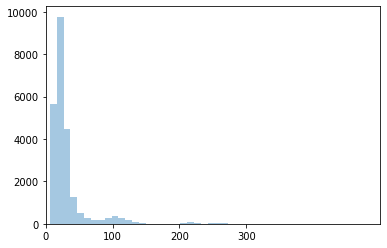

In [64]:

fig, ax = plt.subplots()
sns.distplot(best_grid.predict(X_valid),bins=40, kde=False,ax=ax)
ax.set_xlim(0,500)
ax.set_xticks(range(0,400,100))
plt.show()


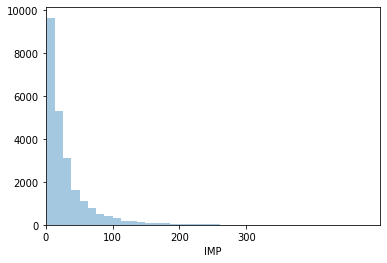

In [66]:
fig, ax = plt.subplots()
sns.distplot(y_valid, kde=False,bins=80,ax=ax)
ax.set_xlim(0,500)
ax.set_xticks(range(0,400,100))
plt.show()



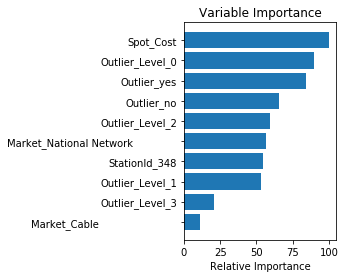

In [45]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-10:]
pos = (np.arange(sorted_idx.shape[0]) + .5)[-10:]
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Predict on Unrated Spots 

In [51]:

unrated = dat.loc[dat.IMP == 0]
unrated['Pred_IMP'] = best_grid.predict(test_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
unrated.head()

,Media,Estimate,Access,DMA,Market,StationId,Length,Date,Time,Spot_Cost,Spot_Type,GRP,IMP,Month,Day_Of_Week,Hour_Slot,Outlier,Outlier_Level,Pred_IMP
0,TV,Q119,GD,900,National Network,37,30,2018-12-31,00:06:00,56.0,INV,0.0,0.0,January,Monday,00,no,0,94.055142
1,TV,Q119,TN,900,Cable,202,30,2018-12-31,00:07:00,56.0,INV,0.0,0.0,January,Monday,00,no,0,28.755617
4,TV,Q119,GD,900,Cable,168,30,2018-12-31,00:10:00,56.0,INV,0.0,0.0,January,Monday,00,no,0,29.911225
5,TV,Q119,GD,900,Cable,305,30,2018-12-31,00:16:00,268.8,INV,0.0,0.0,January,Monday,00,no,0,38.379141
6,TV,Q119,GD,900,Cable,372,30,2018-12-31,00:17:00,80.0,INV,0.0,0.0,January,Monday,00,no,0,33.212668


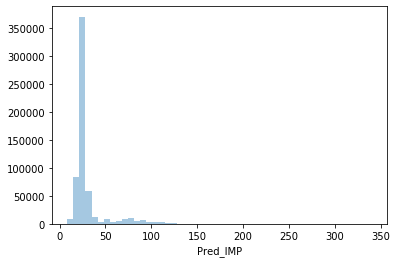

In [53]:
sns.distplot(unrated['Pred_IMP'], kde=False)